In [ ]:
pip install openpyxl

In [ ]:
pip install jieba

In [1]:
target_style = "科幻" # 想要预测的风格

In [2]:
# 导入所需的模块
import tensorflow as tf # tensorflow，深度学习框架
import keras # keras，深度学习框架
import jieba # 用于分词
import re # 正则表达式
import numpy as np # numpy数组
import pandas as pd # pandas表格
import matplotlib.pyplot as plt # 数据可视化
import matplotlib.font_manager as mfm # 用于自定义字体
import openpyxl # 用于读取excel中的数据
from PIL import Image # 读取图像
from tqdm import tqdm # 显示迭代进度条
from sklearn.model_selection import train_test_split # 训练集、验证集、测试集的划分
from itertools import product # 迭代工具
from tensorflow.keras.models import load_model # 加载模型
from sklearn.utils import class_weight # 计算样本权重
from sklearn.metrics import roc_curve, auc # 绘画ROC曲线，计算AUC值
from collections import Counter # 词频统计模块

Using TensorFlow backend.


In [3]:
plt.style.use('ggplot') # 使用ggplot风格
font_path = "../data/simhei.ttf" # 字体路径
prop = mfm.FontProperties(fname=font_path,size=25) # 自定义字体（大字号）
prop_smallsize = mfm.FontProperties(fname=font_path,size=20) # 自定义字体（小字号）

# 读取数据，预处理

In [4]:
data = pd.read_excel(
    '../data/动画信息.xlsx',
     engine='openpyxl') # 读取数据
np.random.seed(233) # 设置随机种子

In [5]:
# 数据预处理：0-1 矩阵
# 目前共提供7个变量：有效前作，主线故事，全为男性，男多于女，女多于男，男女相等
data.index = data["动画ID"]
id_set = set(data["动画ID"])
list1 = ["有效前作","主线故事"]
list2 = ["全为男性","全为女性","男多于女","女多于男","男女相等"]
binary_data = np.zeros((len(data),len(list1)+len(list2)),dtype=np.float32)
for i, j in product(range(0, len(data)), range(0, len(list1) + len(list2))):
    if j < len(list1):
        if np.isnan(data[list1[j]].iloc[i]) == False:
            anime_id = int(data[list1[j]].iloc[i])
            if anime_id in id_set:
                if data.loc[anime_id,target_style] == 1:
                    binary_data[i,j] = 1
                else:
                    binary_data[i,j] = 0
            else:
                binary_data[i,j] = 0
        else:
            binary_data[i,j] = 0
    else:
        binary_data[i,j] = data[list2[j-2]].iloc[i]

In [6]:
# 数据预处理：动画封面

IMSIZE = 128
first_styles, styles = data.columns[4: 14], data.columns[14: 24]
img_file_names = data.loc[:, '动画封面']

imgs = np.zeros([len(img_file_names), IMSIZE, IMSIZE, 3])
print('Loading images...')
for i, img_file_name in tqdm(enumerate(img_file_names)): # lzt:这个tqdm是什么东西（卧槽，好像有点猛）hst:它本来该是个进度条，但是好像在jupyter里面不大好用，py里面没问题
    img = Image.open('../data/动画封面/' + img_file_name)
    img = img.resize([IMSIZE, IMSIZE])
    img = np.array(img, dtype=np.float32) / 255
    imgs[i] = img

5it [00:00, 37.85it/s]

Loading images...


4650it [01:25, 54.63it/s]


In [7]:
# 数据预处理：标签
labels = np.array(data.loc[:, target_style], dtype=np.int32)

# 数据预处理：动画简介
intro_texts = data.loc[:, '动画简介']
intro_texts = [
    [word for word in jieba.lcut(intro_text)]
    for intro_text in intro_texts]

# 数据预处理：动画名
title_texts = data.loc[:, '动画名']
title_texts = [
    [word for word in jieba.lcut(title_text)]
    for title_text in title_texts]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.801 seconds.
Prefix dict has been built successfully.


In [8]:
# 训练集，验证集，测试集的划分
img_halfway,img_test,\
text_halfway,text_test,\
title_halfway,title_test,\
binary_halfway,binary_test,\
label_halfway,label_test = train_test_split(
    imgs, intro_texts, title_texts, binary_data, labels,
    test_size=0.2, 
    stratify=labels,
    random_state=233) # （大）训练集和测试集的划分

img_train,img_val,\
text_train,text_val,\
title_train,title_val,\
binary_train,binary_val,\
label_train,label_val = train_test_split(
    img_halfway, text_halfway, title_halfway, binary_halfway, label_halfway,
    test_size=0.2, 
    stratify=label_halfway,
    random_state=233)  # 训练集和验证集的划分

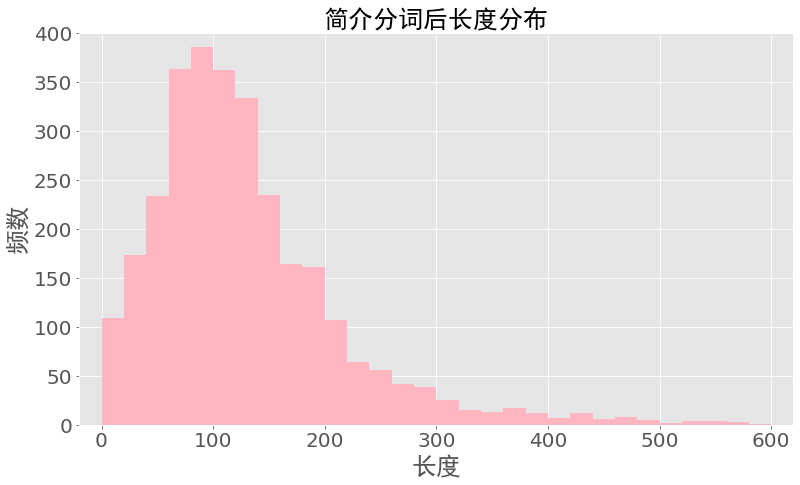

In [9]:
# 数据可视化：分词后简介的长度

intro_lengths = [len(introduction) for introduction in text_train]

fig,axe = plt.subplots(figsize=(12.8,7.2))
plt.tick_params(labelsize=20)
axe.hist(intro_lengths,bins=list(np.arange(0,600+1e-6,600/30)),color="lightpink")
axe.set_xlim([-20,620])
axe.set_ylim([0,400])
axe.set_title("简介分词后长度分布",font_properties=prop)
axe.set_xticks(range(0,601,100))
axe.set_yticks(range(0,401,50))
axe.set_xlabel("长度",font_properties=prop)
axe.set_ylabel("频数",font_properties=prop)
plt.show()

In [10]:
# 数据预处理：动画简介

SENLEN = 400

# VOCAB_SIZE 的决定:训练集上该词出现的次数>=2
train_word_list = [word for sequence in text_train for word in sequence]
word_counter_introduction = Counter(train_word_list)
most_common_word_in_train_introduction = word_counter_introduction.most_common()
VOCAB_SIZE = len(most_common_word_in_train_introduction) + 1 # 设置一个初值，大概率结果不是这个
for i in range(len(most_common_word_in_train_introduction)):
    if most_common_word_in_train_introduction[i][1] <= 1:
        VOCAB_SIZE = i + 1
        break
        
# 对训练集建表
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)

# 将训练集的文本数字化
text_train = tokenizer.texts_to_sequences(text_train)
text_train = keras.preprocessing.sequence.pad_sequences(
    text_train, maxlen=SENLEN, padding='post')

# 将验证集的文本数字化
text_val = tokenizer.texts_to_sequences(text_val)
text_val = keras.preprocessing.sequence.pad_sequences(
    text_val, maxlen=SENLEN, padding='post')

# 将测试集的文本数字化
text_test = tokenizer.texts_to_sequences(text_test)
text_test = keras.preprocessing.sequence.pad_sequences(
    text_test, maxlen=SENLEN, padding='post')

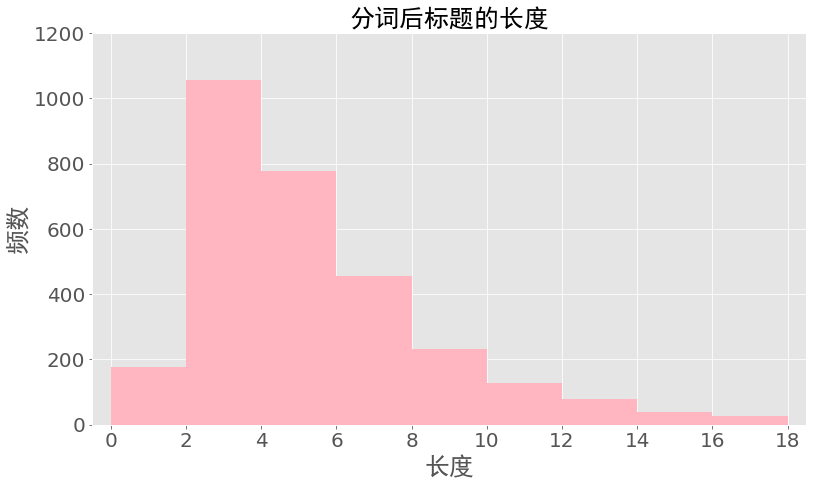

In [11]:
# 数据可视化：分词后标题的长度
title_lengths = [len(title) for title in title_train]
fig,axe = plt.subplots(figsize=(12.8,7.2))
axe.hist(title_lengths,bins=list(np.arange(0,18+1e-6,2)),color="lightpink")
plt.tick_params(labelsize=20)
axe.set_xlim([-0.5,18.5])
axe.set_ylim([0,1200])
axe.set_xticks([0,2,4,6,8,10,12,14,16,18])
axe.set_title("分词后标题的长度",font_properties=prop)
axe.set_xlabel("长度",font_properties=prop)
axe.set_ylabel("频数",font_properties=prop)
plt.show()

In [12]:
# 数据预处理：动画名
SENLEN_TITLE = 16

# VOCAB_SIZE_TITLE 的决定:训练集上该词出现的次数>=2
train_word_list = [word for sequence in title_train for word in sequence]
word_counter_title = Counter(train_word_list)
most_common_word_in_train_title = word_counter_title.most_common()
VOCAB_SIZE_TITLE = len(most_common_word_in_train_title) + 1 # 设置一个初值，大概率结果不是这个
for i in range(len(most_common_word_in_train_title)):
    if most_common_word_in_train_title[i][1] <= 1:
        VOCAB_SIZE_TITLE = i + 1
        break
        
# 对训练集建表
tokenizer_title = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE_TITLE)
tokenizer_title.fit_on_texts(title_train)

# 将训练集的文本数字化
title_train = tokenizer_title.texts_to_sequences(title_train)
title_train = keras.preprocessing.sequence.pad_sequences(
    title_train, maxlen=SENLEN_TITLE, padding='post')

title_val = tokenizer_title.texts_to_sequences(title_val)
title_val = keras.preprocessing.sequence.pad_sequences(
    title_val, maxlen=SENLEN_TITLE, padding='post')

title_test = tokenizer_title.texts_to_sequences(title_test)
title_test = keras.preprocessing.sequence.pad_sequences(
    title_test, maxlen=SENLEN_TITLE, padding='post')

# 载入预训练的模型

In [13]:
model1 = load_model("../result/训练好的模型/{}_model1.h5".format(target_style))
model2 = load_model("../result/训练好的模型/{}_model2.h5".format(target_style))
model3 = load_model("../result/训练好的模型/{}_model3.h5".format(target_style))
model4 = load_model("../result/训练好的模型/{}_model4.h5".format(target_style))
model5 = load_model("../result/训练好的模型/{}_model5.h5".format(target_style))

In [14]:
def ROC(y_true,y_pre,model_name,target_style=target_style):
    fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1) #计算真正率和假正率
    roc_auc = auc(fpr,tpr) #计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC Curve (AUC = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=20)
    plt.yticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=20)
    plt.xlabel('False Positive Rate',fontsize=25)
    plt.ylabel('True Positive Rate',fontsize=25)
    plt.title('ROC curve of {}'.format(model_name),fontsize=25)
    plt.legend(loc="lower right",fontsize=20)
    #plt.savefig("数据可视化图片/{}_ROC curve of {}".format(target_style,model_name),dpi=200)
    plt.show()

# 模型效果重现

<Figure size 432x288 with 0 Axes>

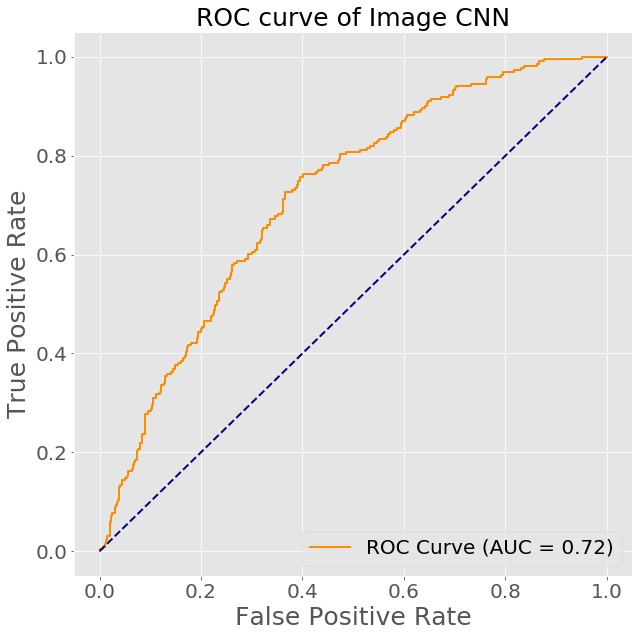

In [15]:
#model1: 输入海报
train_result1 = model1.predict(img_train)
val_result1 = model1.predict(img_val)
test_result1 = model1.predict(img_test)
predict_test = model1.predict(img_test)
ROC(list(label_test.flatten()),predict_test.flatten(),"Image CNN")

<Figure size 432x288 with 0 Axes>

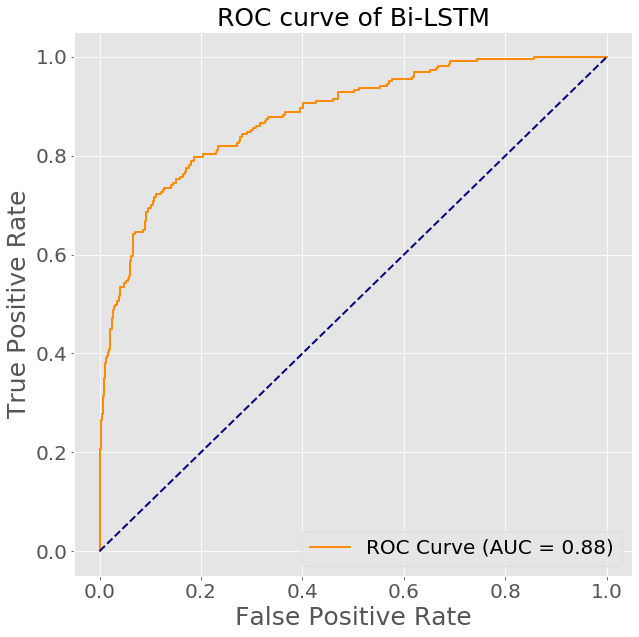

In [16]:
#model2: 输入简介
train_result2 = model2.predict(text_train)
val_result2 = model2.predict(text_val)
test_result2 = model2.predict(text_test)
predict_test = model2.predict(text_test)
ROC(list(label_test.flatten()),predict_test.flatten(),"Bi-LSTM")

<Figure size 432x288 with 0 Axes>

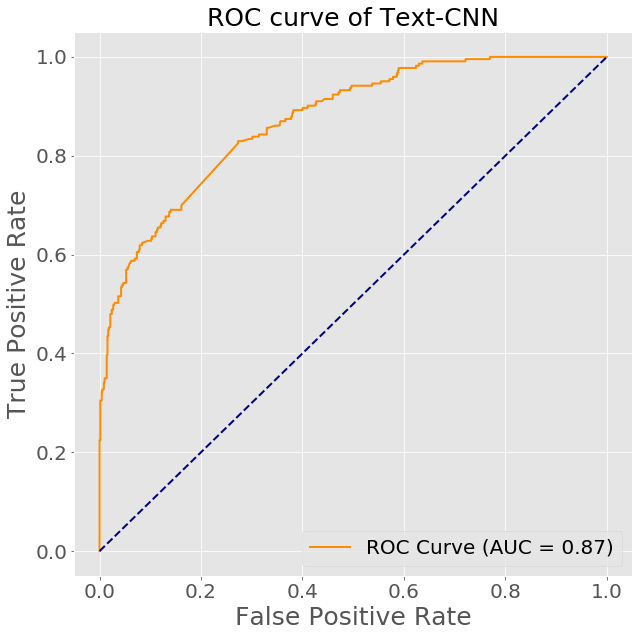

In [17]:
#model3：输入动画名
train_result3 = model3.predict(title_train)
val_result3 = model3.predict(title_val)
test_result3 = model3.predict(title_test)
predict_test = model3.predict(title_test)
ROC(list(label_test.flatten()),predict_test.flatten(),"Text-CNN")

<Figure size 432x288 with 0 Axes>

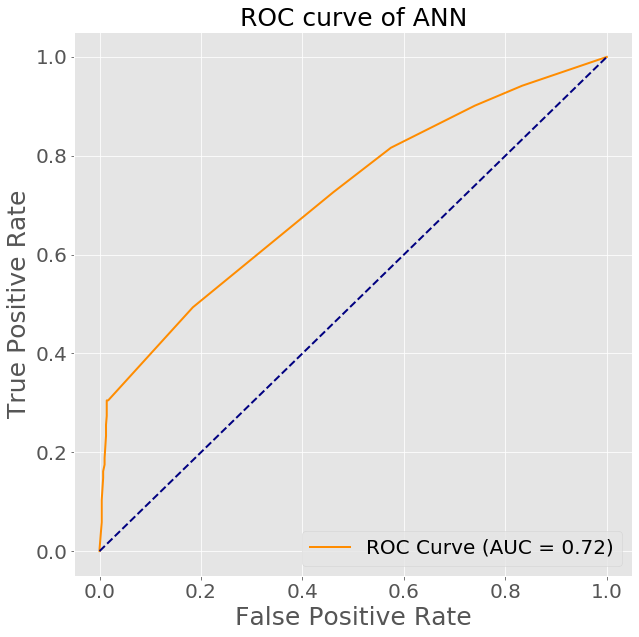

In [18]:
#model4：输入0-1变量
train_result4 = model4.predict(binary_train)
val_result4 = model4.predict(binary_val)
test_result4 = model4.predict(binary_test)
predict_test = model4.predict(binary_test)
ROC(list(label_test.flatten()),predict_test.flatten(),"ANN")

<Figure size 432x288 with 0 Axes>

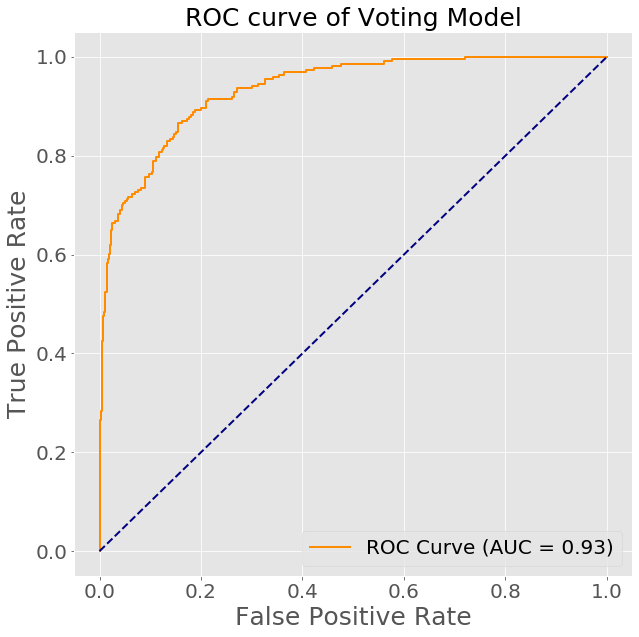

In [19]:
#model5：投票模型
def f(x): # 取sigmoid函数的反函数，然后再标准化
    x = -np.log( 1/x - 1)
    x = (x - np.mean(x)) / np.std(x)
    return x

train_final = np.concatenate((f(train_result1),f(train_result2),f(train_result3),f(train_result4)),axis=1)
val_final = np.concatenate((f(val_result1),f(val_result2),f(val_result3),f(val_result4)),axis=1)
test_final = np.concatenate((f(test_result1),f(test_result2),f(test_result3),f(test_result4)),axis=1)
predict_test = model5.predict(test_final)
ROC(list(label_test.flatten()),predict_test.flatten(),"Voting Model")

In [20]:
y_true = list(label_test.flatten())
y_pre = predict_test.flatten()
fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1)

# 预测新番动画

In [21]:
# 阈值的选择: fpr < 0.05
for i in range(len(fpr)):
    if fpr[i] >= 0.05:
        index = i - 1
        break
predict_threshold = threshold[index]

In [22]:
# 预测一下
data_new = pd.read_excel(
    '../data/用于预测的动画信息.xlsx',
     engine='openpyxl') # 读取数据

预处理

In [23]:
# 数据预处理：0-1 矩阵
# 目前共提供7个变量：有效前作，主线故事，全为男性，男多于女，女多于男，男女相等
binary_data_new = np.zeros((len(data_new),len(list1)+len(list2)),dtype=np.float32)

for i, j in product(range(0, len(data_new)), range(0, len(list1) + len(list2))):
    if j < len(list1):
        if np.isnan(data_new[list1[j]].iloc[i]) == False:
            anime_id = int(data_new[list1[j]].iloc[i])
            if anime_id in id_set:
                if data.loc[anime_id,target_style] == 1:
                    binary_data_new[i,j] = 1
                else:
                    binary_data_new[i,j] = 0
            else:
                binary_data_new[i,j] = 0
        else:
            binary_data_new[i,j] = 0
    else:
        binary_data_new[i,j] = data_new[list2[j-2]].iloc[i]

In [24]:
binary_data_new

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [25]:
# 数据预处理：动画封面

IMSIZE = 128
img_file_names = data_new.loc[:, '动画封面']

imgs_predict = np.zeros([len(img_file_names), IMSIZE, IMSIZE, 3])
print('Loading images...')
for i, img_file_name in tqdm(enumerate(img_file_names)): # lzt:这个tqdm是什么东西（卧槽，好像有点猛）hst:它本来该是个进度条，但是好像在jupyter里面不大好用，py里面没问题
    img = Image.open('../data/用于预测的动画封面/' + img_file_name)
    img = img.resize([IMSIZE, IMSIZE])
    img = np.array(img, dtype=np.float32) / 255
    imgs_predict[i] = img

2it [00:00, 17.99it/s]

Loading images...


5it [00:00, 21.67it/s]


In [26]:
# 数据预处理：动画简介
intro_texts_predict = data_new.loc[:, '动画简介']
intro_texts_predict = [
    [word for word in jieba.lcut(intro_text)]
    for intro_text in intro_texts_predict]

# 数据预处理：动画名
title_texts_predict = data_new.loc[:, '动画名']
title_texts_predict = [
    [word for word in jieba.lcut(title_text)]
    for title_text in title_texts_predict]

In [27]:
# 数据预处理：动画简介,将文本数字化
intro_texts_predict = tokenizer.texts_to_sequences(intro_texts_predict)
intro_texts_predict = keras.preprocessing.sequence.pad_sequences(
    intro_texts_predict, maxlen=SENLEN, padding='post')

In [28]:
# 数据预处理：动画名,将文本数字化
title_texts_predict = tokenizer_title.texts_to_sequences(title_texts_predict)
title_texts_predict = keras.preprocessing.sequence.pad_sequences(
    title_texts_predict, maxlen=SENLEN_TITLE, padding='post')

预测

In [29]:
predict_result1 = model1.predict(imgs_predict)
predict_result2 = model2.predict(intro_texts_predict)
predict_result3 = model3.predict(title_texts_predict)
predict_result4 = model4.predict(binary_data_new)
def g(x,reference):
    x = -np.log( 1/x - 1)
    reference = -np.log( 1/reference - 1)
    x = (x - np.mean(reference)) / np.std(reference)
    return x
final_X_predict = np.concatenate((g(predict_result1,train_result1),g(predict_result2,train_result2),g(predict_result3,train_result3),g(predict_result4,train_result4)),axis=1)
predict_result5 = model5.predict(final_X_predict)

In [30]:
data_new[target_style] = np.zeros(len(data_new),dtype=np.int32)
for i in range(len(data_new)):
    print(data_new.loc[i,"动画名"]+"\t"+target_style,end="")
    if predict_result5[i] > predict_threshold:
        data_new.loc[i,target_style] = 1
        print("\t√")
    else:
        print("\tX")

鬼灭之刃 游郭篇	科幻	X
地球外少年少女	科幻	√
佐佐木与宫野	科幻	X
明日酱的水手服	科幻	X
Slow Loop	科幻	X
